In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.stats import spearmanr # since the data is not normal
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_regression, f_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


In [2]:
train = pd.read_csv("../data/train.csv")
train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1.0,0.0,7.0,0.6,188.0,2.0,...,20.0,756.0,2549.0,9.0,7.0,19,0,0,1,1
1,1021,1,0.5,1,0.0,1.0,53.0,0.7,136.0,3.0,...,905.0,1988.0,2631.0,17.0,3.0,7,1,1,0,2
2,563,1,0.5,1,2.0,1.0,41.0,0.9,145.0,5.0,...,1263.0,1716.0,2603.0,11.0,2.0,9,1,1,0,2
3,615,1,2.5,0,0.0,0.0,10.0,0.8,131.0,6.0,...,1216.0,1786.0,2769.0,16.0,8.0,11,1,0,0,2
4,1821,1,1.2,0,13.0,1.0,44.0,0.6,141.0,2.0,...,1208.0,1212.0,1411.0,8.0,2.0,15,1,1,0,1


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             1995 non-null   float64
 5   four_g         1995 non-null   float64
 6   int_memory     1995 non-null   float64
 7   m_dep          1995 non-null   float64
 8   mobile_wt      1996 non-null   float64
 9   n_cores        1996 non-null   float64
 10  pc             1995 non-null   float64
 11  px_height      1996 non-null   float64
 12  px_width       1998 non-null   float64
 13  ram            1998 non-null   float64
 14  sc_h           1999 non-null   float64
 15  sc_w           1999 non-null   float64
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [4]:
# since the number of null values is small, we can just drop the null values
train.dropna(inplace=True)
pd.set_option('display.max_columns', 500)
train.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000
mean,1238.270718,0.496233,1.522451,0.510799,4.307885,0.520844,32.074335,0.502009,140.263184,4.516323,9.909091,644.800603,1251.115520,2123.632848,12.307885,5.774485,11.001507,0.760924,0.501758,0.505274,1.499247
std,439.641057,0.500111,0.815499,0.500009,4.339735,0.499691,18.138177,0.288622,35.398777,2.291257,6.061019,442.951035,431.924893,1085.051293,4.213061,4.357385,5.464872,0.426626,0.500123,0.500098,1.118539
min,501.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.500000,0.000000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,5.000000,282.500000,875.500000,1207.000000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.000000
50%,1225.000000,0.000000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,10.000000,564.000000,1247.000000,2147.000000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,2.000000
75%,1615.500000,1.000000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,15.000000,947.500000,1633.000000,3065.000000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.000000
max,1998.000000,1.000000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


In [5]:
for i in train.columns:
    if len(train[i].unique()) == 2:
        print(i, "boolean")
        train[i] = train[i].astype(bool)
    if any(train[i] != train[i].astype(int)):
        print(i, "float")
        train[i] = train[i].astype(float)
    else:
        train[i] = train[i].astype(int)
        print(i, "int")

battery_power int
blue boolean
blue int
clock_speed float
dual_sim boolean
dual_sim int
fc int
four_g boolean
four_g int
int_memory int
m_dep float
mobile_wt int
n_cores int
pc int
px_height int
px_width int
ram int
sc_h int
sc_w int
talk_time int
three_g boolean
three_g int
touch_screen boolean
touch_screen int
wifi boolean
wifi int
price_range int


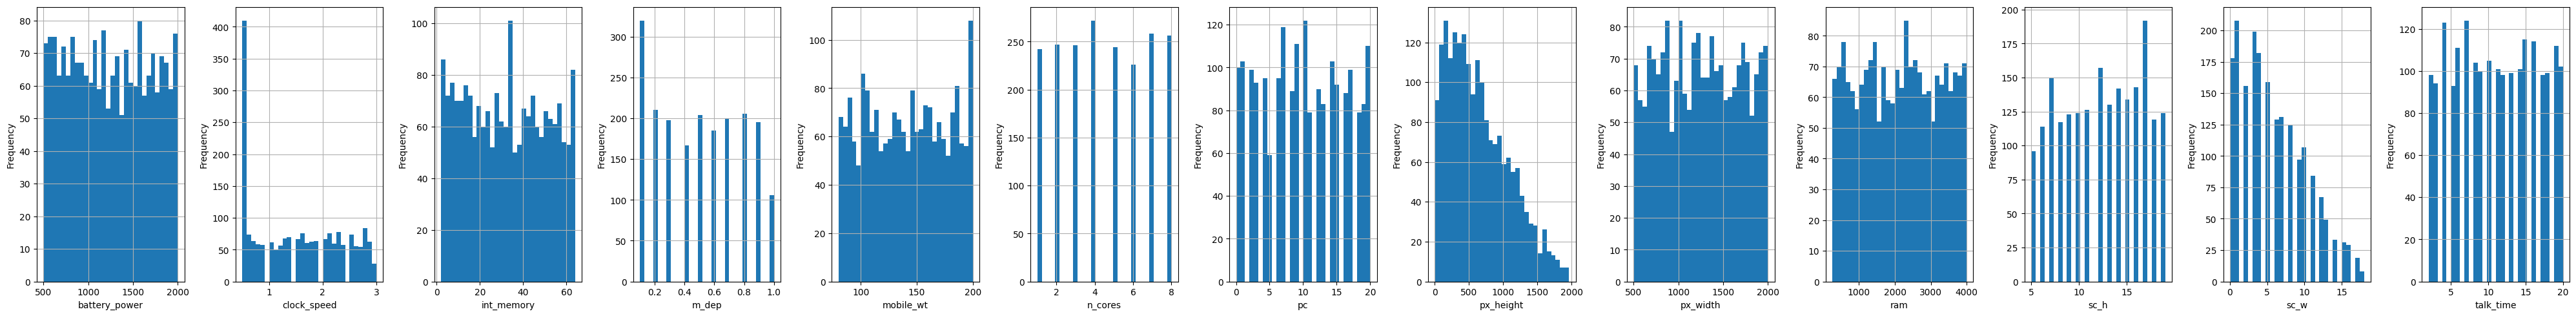

In [6]:
# let's check the distribution of all the data using pair plot
numerical_cols = ["battery_power", "clock_speed", "int_memory", "m_dep","mobile_wt","n_cores" , "pc"	, "px_height", "px_width", "ram","sc_h","sc_w","talk_time"	]

# Example: Plot histograms of all columns beside each other
fig, axs = plt.subplots(1, len(numerical_cols), figsize=(40, 5))  # Adjust figsize as needed

for i, col in enumerate(numerical_cols):
    axs[i].hist(train[col], bins=30)  # Adjust bins as needed
    axs[i].set_xlabel(col)
    axs[i].set_ylabel("Frequency")
    axs[i].grid(True)

plt.tight_layout()
plt.show()


In [7]:
train.corr().loc["price_range"]
# looks like there is a very strong correlation between price_range and RAM amount

battery_power    0.199277
blue             0.021330
clock_speed     -0.006675
dual_sim         0.019108
fc               0.024738
four_g           0.015537
int_memory       0.041812
m_dep           -0.001396
mobile_wt       -0.032168
n_cores          0.004662
pc               0.034716
px_height        0.147956
px_width         0.163319
ram              0.917448
sc_h             0.021643
sc_w             0.038371
talk_time        0.020511
three_g          0.024896
touch_screen    -0.030315
wifi             0.019546
price_range      1.000000
Name: price_range, dtype: float64

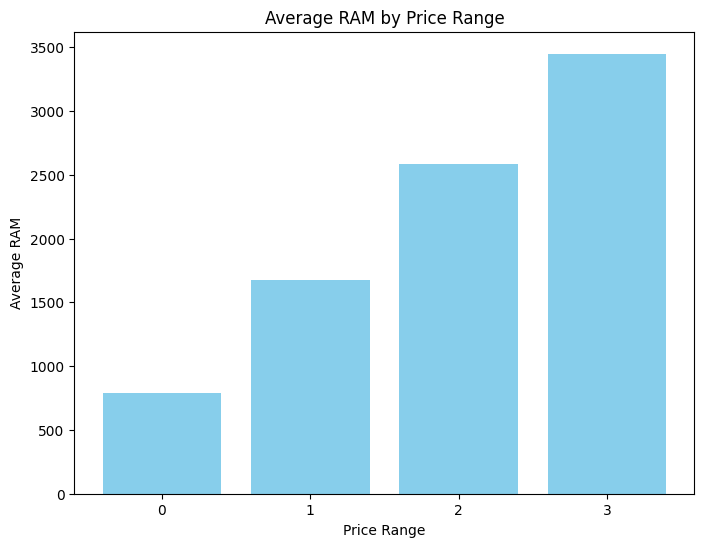

In [8]:
grouped_data = train.groupby("price_range")["ram"].mean().reset_index()
plt.figure(figsize=(8, 6))
plt.bar(grouped_data["price_range"], grouped_data["ram"], color='skyblue')
plt.xlabel("Price Range")
plt.ylabel("Average RAM")
plt.title("Average RAM by Price Range")
plt.xticks(grouped_data["price_range"])
plt.show()

In [9]:
def find_outliers(df):
    outliers = {}
    values = {}
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            col_outlier = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            if col_outlier.shape[0] > 0:    
                outliers[col] = col_outlier.shape[0]
                values[col] = {
                    "outliers": list(col_outlier[col])
                    , "lower_bound": lower_bound
                    , "upper_bound": upper_bound
                }   
    return outliers, values

# Find outliers
outliers, values = find_outliers(train)
print(outliers)
print(values)


{'fc': 18, 'px_height': 2, 'three_g': 476}
{'fc': {'outliers': [18, 17, 18, 17, 17, 18, 17, 17, 18, 18, 18, 17, 18, 18, 19, 18, 18, 18], 'lower_bound': -8.0, 'upper_bound': 16.0}, 'px_height': {'outliers': [1949, 1960], 'lower_bound': -715.0, 'upper_bound': 1945.0}, 'three_g': {'outliers': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Regarding the outliers:
<br>
1- the outliers in FC give are on the higher end which we explore in the next section
<br>
2- the outliers in px_height seem to be very close to the upper bound which gives a good signal
<br>
3- the ouliers in three_g means nothing since it's a catigorical unbalanced variable

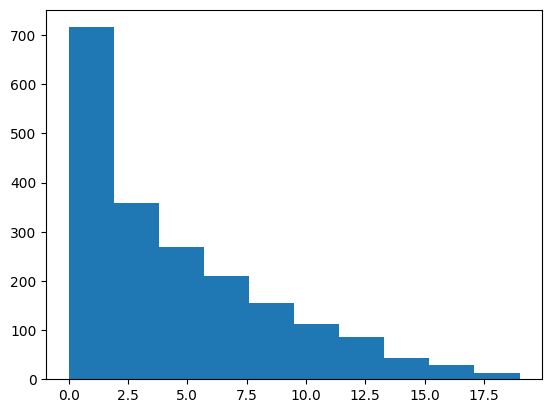

In [10]:
plt.hist(train['fc'])
plt.show()

In [11]:
# we can conclude that there is a lot of phones here that don't include a front camera so their pixel size is typed as 0
# this causes other records to be percieved as outliers which is not the case
# We will remove all records with 0 pixel size and then test the correlations again
train_temp = train[train['fc'] != 0]
spearmanr(train_temp['fc'], train_temp['price_range'])

SignificanceResult(statistic=0.013963063585717606, pvalue=0.5864696164493328)

In [12]:
# let's test the biserial correlation coefficient
import scipy.stats as stats
temp_range = train_temp['price_range'].astype('category').cat.codes
anova = stats.pointbiserialr(temp_range, train_temp['fc'])
anova

SignificanceResult(statistic=0.015337291510745345, pvalue=0.5501729934653677)

The front camera variable doesn't seem to affect the price range directly 

In [13]:
# now let's convert the front camera into a binary variable and test again
# Create a contingency table
fc_bin = (train["fc"] == 0).astype(int)
contingency_table = pd.crosstab(fc_bin, train["price_range"])

# Perform Chi-square test
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
print("Chi-square statistic:", chi2)
print("p-value:", p_value)

Chi-square statistic: 2.0438681719624183
p-value: 0.5633518045128003


In [14]:
# upon exploring the px_height variable I found that there are very small values which doesn't make since at all since minimum pixel height 
# should be at least 240 as far as I know.
train[["px_height", "px_width"]][train["px_height"] < 100]

,px_height,px_width
0,20,756
32,85,1152
47,27,774
73,4,638
86,96,741
...,...,...
1948,88,709
1954,64,745
1963,3,629
1972,42,807


In [15]:
# though the number inside px_height don't make sense, the correlation is expected since probably there is a correlation between how big 
# a screen is and how high the screen is.
# maybe it's normalized to a different scale? not sure
train[["px_height", "px_width"]].corr()

,px_height,px_width
px_height,1.000000,0.509599
px_width,0.509599,1.000000


# Model Training

Since the price range is ordinal, a regression model will be better suited for this data

In [16]:
# Lets train a linear regression model to predict the price of the device


X_train, X_test, y_train_notscaled, y_test = train_test_split(train.drop(columns=["price_range"]), train["price_range"], test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
scaler_label = StandardScaler()
y_train = scaler_label.fit_transform(y_train_notscaled.values.reshape(-1, 1))


In [17]:
# Suppress future warnings and convergence warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(),
    "Ridge Regression": Ridge(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Support Vector Regressor": LinearSVR()
}
def apply_rfe(model, X_train, y_train, X_test, n_features_to_select=5):
    selector = RFE(model, n_features_to_select=n_features_to_select, step=1)
    selector = selector.fit(X_train, y_train)
    return selector.transform(X_train), selector.transform(X_test)
def apply_selectkbest(X_train, y_train, X_test, k=5):
    selector = SelectKBest(score_func=mutual_info_regression, k=k)
    selector.fit(X_train, y_train)
    return selector.transform(X_train), selector.transform(X_test)
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = scaler_label.inverse_transform(np.array(y_pred).reshape(-1, 1))
    return mean_squared_error(y_test, y_pred)

n_features = 15 # tried  from 10 -> 20 manually .. 15 seemed like it produced the best results overall

for name, model in models.items():
    print(f"model: {name}")
    X_train_rfe, X_test_rfe = apply_rfe(model, X_train, y_train, X_test, n_features) #using RFE
    mse_rfe = evaluate_model(model, X_train_rfe, y_train, X_test_rfe, y_test)
    print(f"mse with RFE            : {mse_rfe}")
    X_train_kbest, X_test_kbest = apply_selectkbest(X_train, y_train, X_test, n_features) # using kbest
    mse_kbest = evaluate_model(model, X_train_kbest, y_train, X_test_kbest, y_test)
    print(f"mse with SelectKBest    : {mse_kbest}")
    mse_no_fs = evaluate_model(model, X_train, y_train, X_test, y_test) # no featurn selection
    print(f"mse no feature selection: {mse_no_fs}")
    print("------------------------------------")


model: Linear Regression
mse with RFE            : 0.09837859268348435
mse with SelectKBest    : 0.0985019952740576
mse no feature selection: 0.09843372810736171
------------------------------------
model: Lasso Regression
mse with RFE            : 1.2675899164577058
mse with SelectKBest    : 1.2675899164577058
mse no feature selection: 1.2675899164577058
------------------------------------
model: Ridge Regression
mse with RFE            : 0.09840123686807618
mse with SelectKBest    : 0.09863710534086291
mse no feature selection: 0.09845506113564062
------------------------------------
model: Decision Tree Regressor
mse with RFE            : 0.17794486215538843
mse with SelectKBest    : 0.19548872180451127
mse no feature selection: 0.21052631578947367
------------------------------------
model: Random Forest Regressor
mse with RFE            : 0.07719573934837089
mse with SelectKBest    : 0.0712551378446115
mse no feature selection: 0.07534511278195487
--------------------------------

In [18]:
mlp_regressor = MLPRegressor(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', max_iter=500, alpha=0.0001)
mlp_regressor.fit(X_train, y_train)
y_pred = mlp_regressor.predict(X_test)
y_pred = scaler_label.inverse_transform(np.array(y_pred).reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error for MLPRegressor:", mse)

Mean Squared Error for MLPRegressor: 0.15789082425161338


In [19]:
xgbregressor_regressor = XGBRegressor(max_depth = 5, learning_rate = .1, n_estimators = 500)
xgbregressor_regressor.fit(X_train, y_train_notscaled)
y_pred = xgbregressor_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error for XGBRegressor:", mse)

Mean Squared Error for XGBRegressor: 0.07594236319851534


In [20]:
catboost_regressor = CatBoostRegressor(verbose=0)
catboost_regressor.fit(X_train, y_train_notscaled)
y_pred = catboost_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error for CatBoost:", mse)

Mean Squared Error for CatBoost: 0.07294964775003009


In [29]:
from sklearn.ensemble import AdaBoostRegressor
base_estimator = DecisionTreeRegressor()
adaboost_regressor = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=500, learning_rate=1.0, random_state=42)
adaboost_regressor.fit(X_train, y_train_notscaled)
y_pred = adaboost_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error for Adaboost:", mse)


Mean Squared Error for Adaboost: 0.06516290726817042


In [32]:
transformed_classes = np.clip(y_pred, 0, 3)
print("Accuracy of the model", sum(transformed_classes==y_test)/len(y_test))

Accuracy of the model 0.9348370927318296


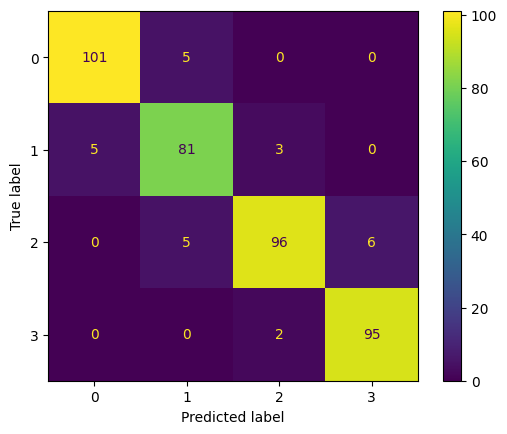

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, transformed_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
disp.plot()
plt.show()

In [24]:
import joblib
joblib.dump(adaboost_regressor, '../model/adaboost_model.pkl')


['../model/adaboost_model.pkl']

In [25]:
joblib.dump(scaler, "../model/normalizer.pkl")

['../model/normalizer.pkl']